# Speaker identification using VGG Classiffier 

This notebook tests applies static image (frame-by-frame) face detection for speaker re-identification in videos and demostrates that state of the art face detection techniques are deceived by fake videos that use face swapping techniques. Reference for VGG model implementation in Python: https://github.com/rcmalli/keras-vggface

## Load libraries and Define Parameters

In [20]:
#---IMPORTING PACKAGES
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Basic Libraries
import numpy as np
import dlib
import cv2
import random
import time
from scipy import interp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure

# Keras & sklearn
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense, Input, Lambda, Average, Flatten
from keras.models import Model
from keras.callbacks import Callback
from keras import backend as B
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Independent Dev libraries
from keras_vggface import utils #(reference: https://github.com/rcmalli/keras-vggface)
from keras_vggface.vggface import VGGFace
import imutils #https://github.com/jrosebr1/imutils
from test import get_number_of_records,read_and_decode #tfrecords utilities



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#---DEFINING PARAMETERS
input_path='/home/ubuntu/fakebusters/data/'
bs=16
n_frames=32
image_height = 70
image_width = 70
sequence_shape=(n_frames,197,197,3) # ResNets needs a size of at least 197
people=['putin','warren','justin', 'may', 'modi', 'trump', 'hillary', 'obama', 'pelosi', 'bernie', 'michelle', 'biden']
lb=LabelBinarizer()
lb.fit(people)


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

## Load and transform data

### Scripts

In [ ]:
# Load Data from memory - Outputs tuple of x,y
train_data=mem_load(input_path,people,n_frames,mode="train")
test_data=mem_load(input_path,people,n_frames,mode="test")
fakes_data=mem_load(input_path,people,n_frames,mode="fakes")
impo_data=mem_load(input_path,people,n_frames,mode="imposter")

Loading train data for: putin
Loading train data for: warren
Loading train data for: justin
Loading train data for: may
Loading train data for: modi
Loading train data for: trump
Loading train data for: hillary
Loading train data for: obama
Loading train data for: pelosi
Loading train data for: bernie
Loading train data for: michelle
Loading train data for: biden
Loading test data for: putin
Loading test data for: warren
Loading test data for: justin
Loading test data for: may
Loading test data for: modi
Loading test data for: trump
Loading test data for: hillary
Loading test data for: obama
Loading test data for: pelosi
Loading test data for: bernie
Loading test data for: michelle
Loading test data for: biden
Loading fakes data for: putin
Loading fakes data for: warren
Loading fakes data for: justin
Loading fakes data for: may
Loading fakes data for: modi
Loading fakes data for: trump
Loading fakes data for: hillary
Loading fakes data for: obama
Loading fakes data for: pelosi
Loading 

In [ ]:
# ---TRANSFORM DATA(single list and resize)
train_pro=data_proc(train_data)
test_pro=data_proc(test_data)
fakes_pro=data_proc(fakes_data)
impo_pro=data_proc(impo_data)
print('Train data shape: {}'.format(train_pro[0].shape))
print('Test data shape: {}'.format(test_pro[0].shape))
print('Fakes data shape: {}'.format(fakes_pro[0].shape))
print('Imposter data shape: {}'.format(impo_pro[0].shape))

### Functions / Classes

In [4]:
# Function that reads, transforms and loads data from disk into memory

def mem_load(input_path,people,n_frames,mode="train"): 
    
    seq_collection=[]
    label_collection=[]
    lb=LabelBinarizer()
    lb.fit(people)
    
    for person in people:
        
        
        print('Loading '+mode+' data for: {}'.format(person))
        # Load Videos
        person_videos=[]
        file_path=[input_path+mode+'/tf_records/'+person+'/'+'batch_1_of_1.tfrecords']
        num_videos,videos=get_number_of_records(file_path, n_frames)
        seq_collection.append(videos)
        
        # Load Labels
        person_labels=[person]*num_videos
        person_onehot=np.array(lb.transform(person_labels))
        label_collection.append(person_onehot)
        
    return np.array(seq_collection),np.array(label_collection)



# Random data generation (used to load data from disk by batches)
# Example for data generating function - https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def data_gen(seq_collection,label_collection,bs):
    
    while True:
        x_batch = [] #(each sequence has 32 frames of size 70x70x3)
        y_batch = []

        #Randomly select person

        # Loop that generates samples until size batch size (bs) is reached
        while len(x_batch) < bs:
            person_ix=random.randint(0, len(seq_collection)-1)
            no_samples=len(seq_collection[person_ix])
            seq_ix=random.randint(0, no_samples-1)
            seq_i=seq_collection[person_ix][seq_ix]
            seq_i=pre_process(seq_i) # Resize in order to process in ResNet
            lab_i=label_collection[person_ix][seq_ix]

            x_batch.append(seq_i)
            y_batch.append(lab_i)

        yield (np.array(x_batch),np.array(y_batch))
         


In [ ]:
# [TEST] Data loading function

# Train mode
#input_path='/Users/dsrincon/Dropbox/Personal/EDU/Posgrado/masters_usa/MIMS/2019-I/cs282_deep_neural_networks/assignments/project/data/'
input_path='/home/ubuntu/fakebusters/data/'
bs=12
n_frames=32
#yield_tuple=next(data_gen(input_path,people,lb, bs,n_frames,mode="train", aug=None))
#batch_sequences=yield_tuple[0]
#batch_labels=yield_tuple[1]
#print(batch_sequences.shape)
data=mem_load(input_path,people,n_frames,mode="train")
data_x=data[0]
data_y=data[1]
print(data_x[0].shape)


In [ ]:
# Data processing function: Turns collection (list of lists) into single array
def data_proc(data):
    data_x=[]
    data_y=[]
    seq_collection=data[0]
    lab_collection=data[1]
    for i in range(len(seq_collection)):
        for j in range(len(seq_collection[i])):
            scaled_seq=pre_process(seq_collection[i][j])
            data_x.append(scaled_seq)
            data_y.append(lab_collection[i][j])
      
    data_x=np.array(data_x)
    data_y=np.array(data_y)
    return (data_x,data_y)

In [10]:
# Image pre-processing function (rezises each image in sequence of frames)
def pre_process(images):
  processed_images = []
  for n in range(images.shape[0]):
    image = images[n]
    image = cv2.resize(image,  (197, 197))
    processed_images.append(image)
  processed_images = np.array(processed_images, dtype=np.float32)
  return processed_images

(32, 197, 197, 3)


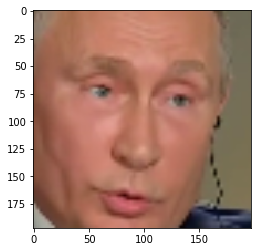

In [46]:
# [TEST] pre-process images 
proc_im=pre_process(train_data[0][0][0])
print(proc_im.shape)
plt.imshow(proc_im[0].astype(np.uint8))
plt.show()

## Model Definition and Training

### Scripts

In [53]:
# Load pretrained vgg model (weights are downloaded first time)
# Reference: https://github.com/rcmalli/keras-vggface
B.clear_session()
vgg_features = VGGFace(include_top=False,model='resnet50',weights='vggface', input_shape=(sequence_shape[1:]), pooling='avg')

In [55]:
# Freeze layers for VGGFace model
for layer in vgg_features.layers:
    layer.trainable = False

In [56]:
# ---INITIATE MODEL

# Define model parameters
train_data_size=np.sum(np.array([len(sample) for sample in train_data[0]]))
tr_epoch_steps=train_data_size//bs
test_data_size=np.sum(np.array([len(sample) for sample in test_data[0]]))
te_epoch_steps=test_data_size//bs
NUM_EPOCHS=1

seq_shape=(32,197,197,3)

# Uncomment (and adjust!) if data generation wants to be used 
'''
# Initialize data generation functions
trainGen=data_gen(train_data[0],train_data[1],bs)
#testGen=data_gen(test_data[0],test_data[1],bs)

# Instantiate model and fit data
model=vggf_classif(seq_shape=sequence_shape,vgg_features=vgg_features).model

model.fit_generator(trainGen, 
                    steps_per_epoch=tr_epoch_steps,
                    validation_data=testGen,
                    validation_steps=te_epoch_steps,
                    epochs=NUM_EPOCHS,verbose=2)
'''

model=vggf_classif(seq_shape=sequence_shape,vgg_features=vgg_features).model




In [16]:
# Model summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 197, 197, 3)   0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 197, 197, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 116427)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1397136   
Total params: 1,397,136
Trainable params: 1,397,136
Non-trainable params: 0
_________________________________________________________________


In [57]:
# ---TRAIN MODEL
out_batch = NBatchLogger(display=1)
model.fit(train_pro[0], train_pro[1],validation_data=(test_pro[0], test_pro[1]),callbacks=[out_batch],epochs=3, batch_size=1,verbose=2)


Train on 2066 samples, validate on 256 samples
Epoch 1/3

1/2066 - Batch Loss: 4.9866814613342285

2/2066 - Batch Loss: 7.187058448791504

3/2066 - Batch Loss: 4.3198981285095215

4/2066 - Batch Loss: 5.753268241882324

5/2066 - Batch Loss: 7.081833362579346

6/2066 - Batch Loss: 5.941303730010986

7/2066 - Batch Loss: 0.8299302458763123

8/2066 - Batch Loss: 4.873599529266357

9/2066 - Batch Loss: 3.9108667373657227

10/2066 - Batch Loss: 2.0687832832336426

11/2066 - Batch Loss: 2.6480886936187744

12/2066 - Batch Loss: 12.547959327697754

13/2066 - Batch Loss: 2.8038222789764404

14/2066 - Batch Loss: 7.894101619720459

15/2066 - Batch Loss: 12.514304161071777

16/2066 - Batch Loss: 1.7958924770355225

17/2066 - Batch Loss: 14.536786079406738

18/2066 - Batch Loss: 2.86690092086792

19/2066 - Batch Loss: 10.281888008117676

20/2066 - Batch Loss: 7.51052713394165

21/2066 - Batch Loss: 5.331124782562256

22/2066 - Batch Loss: 15.482150077819824

23/2066 - Batch Loss: 4.21113443374633


196/2066 - Batch Loss: 2.9757206439971924

197/2066 - Batch Loss: 1.775631070137024

198/2066 - Batch Loss: 1.4015558958053589

199/2066 - Batch Loss: 0.9934490919113159

200/2066 - Batch Loss: 2.0931365489959717

201/2066 - Batch Loss: 0.7802363038063049

202/2066 - Batch Loss: 8.467310905456543

203/2066 - Batch Loss: 3.7503745555877686

204/2066 - Batch Loss: 0.7369314432144165

205/2066 - Batch Loss: 2.6749916076660156

206/2066 - Batch Loss: 0.25060808658599854

207/2066 - Batch Loss: 0.7021008729934692

208/2066 - Batch Loss: 2.5949416160583496

209/2066 - Batch Loss: 0.2756482660770416

210/2066 - Batch Loss: 1.8142023086547852

211/2066 - Batch Loss: 5.524534225463867

212/2066 - Batch Loss: 1.0676090717315674

213/2066 - Batch Loss: 0.19495782256126404

214/2066 - Batch Loss: 6.98669958114624

215/2066 - Batch Loss: 1.6866346597671509

216/2066 - Batch Loss: 1.903594970703125

217/2066 - Batch Loss: 2.738403558731079

218/2066 - Batch Loss: 4.269162178039551

219/2066 - Batch


388/2066 - Batch Loss: 0.13951729238033295

389/2066 - Batch Loss: 4.206238746643066

390/2066 - Batch Loss: 0.631985068321228

391/2066 - Batch Loss: 3.232011318206787

392/2066 - Batch Loss: 0.3660968244075775

393/2066 - Batch Loss: 0.260675847530365

394/2066 - Batch Loss: 0.8431241512298584

395/2066 - Batch Loss: 0.23033808171749115

396/2066 - Batch Loss: 2.552389621734619

397/2066 - Batch Loss: 0.30244070291519165

398/2066 - Batch Loss: 1.0875314474105835

399/2066 - Batch Loss: 0.22661669552326202

400/2066 - Batch Loss: 0.8610827922821045

401/2066 - Batch Loss: 0.61053866147995

402/2066 - Batch Loss: 7.0228986740112305

403/2066 - Batch Loss: 0.4019128084182739

404/2066 - Batch Loss: 4.353391647338867

405/2066 - Batch Loss: 0.3838377892971039

406/2066 - Batch Loss: 0.42311954498291016

407/2066 - Batch Loss: 0.2545439302921295

408/2066 - Batch Loss: 0.2456115484237671

409/2066 - Batch Loss: 0.20938743650913239

410/2066 - Batch Loss: 0.48051610589027405

411/2066 - 


578/2066 - Batch Loss: 0.17342834174633026

579/2066 - Batch Loss: 0.9212296009063721

580/2066 - Batch Loss: 0.13914361596107483

581/2066 - Batch Loss: 0.1279630959033966

582/2066 - Batch Loss: 0.4660083055496216

583/2066 - Batch Loss: 0.003680855967104435

584/2066 - Batch Loss: 0.6960222125053406

585/2066 - Batch Loss: 0.12694384157657623

586/2066 - Batch Loss: 0.15236449241638184

587/2066 - Batch Loss: 0.12769263982772827

588/2066 - Batch Loss: 0.1058025062084198

589/2066 - Batch Loss: 1.0282968282699585

590/2066 - Batch Loss: 0.7299604415893555

591/2066 - Batch Loss: 0.3105151951313019

592/2066 - Batch Loss: 0.37043121457099915

593/2066 - Batch Loss: 0.6312934160232544

594/2066 - Batch Loss: 0.049147021025419235

595/2066 - Batch Loss: 0.05567202344536781

596/2066 - Batch Loss: 0.1688898503780365

597/2066 - Batch Loss: 0.044729895889759064

598/2066 - Batch Loss: 3.0477583408355713

599/2066 - Batch Loss: 2.002986192703247

600/2066 - Batch Loss: 0.3598285019397735


766/2066 - Batch Loss: 0.05346344783902168

767/2066 - Batch Loss: 0.04249799996614456

768/2066 - Batch Loss: 0.10361472517251968

769/2066 - Batch Loss: 0.17181825637817383

770/2066 - Batch Loss: 0.051326245069503784

771/2066 - Batch Loss: 0.0462496280670166

772/2066 - Batch Loss: 0.00721037806943059

773/2066 - Batch Loss: 0.11276208609342575

774/2066 - Batch Loss: 0.02997981384396553

775/2066 - Batch Loss: 0.1267407089471817

776/2066 - Batch Loss: 0.013772661797702312

777/2066 - Batch Loss: 0.032716069370508194

778/2066 - Batch Loss: 0.5747315287590027

779/2066 - Batch Loss: 0.23958875238895416

780/2066 - Batch Loss: 0.10347907245159149

781/2066 - Batch Loss: 0.5388830304145813

782/2066 - Batch Loss: 0.1087549552321434

783/2066 - Batch Loss: 0.02479773759841919

784/2066 - Batch Loss: 0.07216276228427887

785/2066 - Batch Loss: 0.2610552906990051

786/2066 - Batch Loss: 0.03580436855554581

787/2066 - Batch Loss: 0.11822924762964249

788/2066 - Batch Loss: 0.187284871


953/2066 - Batch Loss: 0.04435498267412186

954/2066 - Batch Loss: 0.19986726343631744

955/2066 - Batch Loss: 0.2756466269493103

956/2066 - Batch Loss: 0.3679072856903076

957/2066 - Batch Loss: 0.18231672048568726

958/2066 - Batch Loss: 0.042669229209423065

959/2066 - Batch Loss: 0.24152544140815735

960/2066 - Batch Loss: 0.07517585158348083

961/2066 - Batch Loss: 0.15282481908798218

962/2066 - Batch Loss: 0.25518766045570374

963/2066 - Batch Loss: 0.18803149461746216

964/2066 - Batch Loss: 0.08435232192277908

965/2066 - Batch Loss: 0.11086012423038483

966/2066 - Batch Loss: 0.06122351810336113

967/2066 - Batch Loss: 0.07632126659154892

968/2066 - Batch Loss: 0.009319744072854519

969/2066 - Batch Loss: 0.11204124242067337

970/2066 - Batch Loss: 0.034717366099357605

971/2066 - Batch Loss: 0.031745683401823044

972/2066 - Batch Loss: 0.03213590383529663

973/2066 - Batch Loss: 0.2553025186061859

974/2066 - Batch Loss: 0.016826437786221504

975/2066 - Batch Loss: 0.1251


1136/2066 - Batch Loss: 0.028712689876556396

1137/2066 - Batch Loss: 0.055083177983760834

1138/2066 - Batch Loss: 0.034009307622909546

1139/2066 - Batch Loss: 0.1130257323384285

1140/2066 - Batch Loss: 0.7641205787658691

1141/2066 - Batch Loss: 0.2596191167831421

1142/2066 - Batch Loss: 0.05172537639737129

1143/2066 - Batch Loss: 0.022581063210964203

1144/2066 - Batch Loss: 0.10310638695955276

1145/2066 - Batch Loss: 0.21394938230514526

1146/2066 - Batch Loss: 0.10532570630311966

1147/2066 - Batch Loss: 1.719086766242981

1148/2066 - Batch Loss: 0.0654887706041336

1149/2066 - Batch Loss: 0.011869138106703758

1150/2066 - Batch Loss: 0.006197604350745678

1151/2066 - Batch Loss: 0.1545076072216034

1152/2066 - Batch Loss: 0.18025605380535126

1153/2066 - Batch Loss: 0.5941040515899658

1154/2066 - Batch Loss: 1.3838069438934326

1155/2066 - Batch Loss: 0.290637731552124

1156/2066 - Batch Loss: 0.1476302593946457

1157/2066 - Batch Loss: 0.45306727290153503

1158/2066 - Bat


1319/2066 - Batch Loss: 0.07945062220096588

1320/2066 - Batch Loss: 0.07938312739133835

1321/2066 - Batch Loss: 0.07841430604457855

1322/2066 - Batch Loss: 0.08179199695587158

1323/2066 - Batch Loss: 0.02800561860203743

1324/2066 - Batch Loss: 0.006704163271933794

1325/2066 - Batch Loss: 0.022993583232164383

1326/2066 - Batch Loss: 0.15511026978492737

1327/2066 - Batch Loss: 0.10548201203346252

1328/2066 - Batch Loss: 0.047702401876449585

1329/2066 - Batch Loss: 0.01848827488720417

1330/2066 - Batch Loss: 0.2259664386510849

1331/2066 - Batch Loss: 0.011959737166762352

1332/2066 - Batch Loss: 0.010822895914316177

1333/2066 - Batch Loss: 0.05620945245027542

1334/2066 - Batch Loss: 0.028636323288083076

1335/2066 - Batch Loss: 0.10116075724363327

1336/2066 - Batch Loss: 0.049747731536626816

1337/2066 - Batch Loss: 0.03276250511407852

1338/2066 - Batch Loss: 0.21265658736228943

1339/2066 - Batch Loss: 0.014711176045238972

1340/2066 - Batch Loss: 0.0388411320745945

134


1501/2066 - Batch Loss: 0.12363917380571365

1502/2066 - Batch Loss: 0.36622902750968933

1503/2066 - Batch Loss: 0.36252546310424805

1504/2066 - Batch Loss: 0.06061385199427605

1505/2066 - Batch Loss: 0.10253820568323135

1506/2066 - Batch Loss: 0.005233308300375938

1507/2066 - Batch Loss: 0.03803250193595886

1508/2066 - Batch Loss: 0.042062003165483475

1509/2066 - Batch Loss: 0.024480856955051422

1510/2066 - Batch Loss: 0.01468425989151001

1511/2066 - Batch Loss: 0.055878933519124985

1512/2066 - Batch Loss: 0.2946597635746002

1513/2066 - Batch Loss: 0.039066463708877563

1514/2066 - Batch Loss: 0.018505943939089775

1515/2066 - Batch Loss: 0.012589996680617332

1516/2066 - Batch Loss: 1.2805724143981934

1517/2066 - Batch Loss: 0.06072487309575081

1518/2066 - Batch Loss: 0.16209165751934052

1519/2066 - Batch Loss: 0.005345300305634737

1520/2066 - Batch Loss: 0.2550051212310791

1521/2066 - Batch Loss: 0.030573908239603043

1522/2066 - Batch Loss: 0.05492284521460533

152


1682/2066 - Batch Loss: 0.1286858767271042

1683/2066 - Batch Loss: 0.04050591215491295

1684/2066 - Batch Loss: 0.09679374098777771

1685/2066 - Batch Loss: 0.01096353679895401

1686/2066 - Batch Loss: 0.021897869184613228

1687/2066 - Batch Loss: 0.03763124719262123

1688/2066 - Batch Loss: 0.042679619044065475

1689/2066 - Batch Loss: 0.03171658143401146

1690/2066 - Batch Loss: 0.023161686956882477

1691/2066 - Batch Loss: 0.011371290311217308

1692/2066 - Batch Loss: 0.024343127384781837

1693/2066 - Batch Loss: 0.12161249667406082

1694/2066 - Batch Loss: 0.054301775991916656

1695/2066 - Batch Loss: 0.02436883933842182

1696/2066 - Batch Loss: 0.012648969888687134

1697/2066 - Batch Loss: 0.04586471989750862

1698/2066 - Batch Loss: 0.16541826725006104

1699/2066 - Batch Loss: 0.07746831327676773

1700/2066 - Batch Loss: 0.01784706674516201

1701/2066 - Batch Loss: 0.00987544097006321

1702/2066 - Batch Loss: 0.04312914237380028

1703/2066 - Batch Loss: 0.05806581676006317

170


1863/2066 - Batch Loss: 0.9573800563812256

1864/2066 - Batch Loss: 0.0062375483103096485

1865/2066 - Batch Loss: 0.03832763433456421

1866/2066 - Batch Loss: 0.008284698240458965

1867/2066 - Batch Loss: 0.2595101594924927

1868/2066 - Batch Loss: 0.006268737372010946

1869/2066 - Batch Loss: 0.029096083715558052

1870/2066 - Batch Loss: 0.020979370921850204

1871/2066 - Batch Loss: 0.019226135686039925

1872/2066 - Batch Loss: 0.10121621936559677

1873/2066 - Batch Loss: 0.009046582505106926

1874/2066 - Batch Loss: 0.017557917162775993

1875/2066 - Batch Loss: 0.008397754281759262

1876/2066 - Batch Loss: 0.07881304621696472

1877/2066 - Batch Loss: 0.099674753844738

1878/2066 - Batch Loss: 0.06178955361247063

1879/2066 - Batch Loss: 0.41578736901283264

1880/2066 - Batch Loss: 0.008474934846162796

1881/2066 - Batch Loss: 0.14712059497833252

1882/2066 - Batch Loss: 0.012709878385066986

1883/2066 - Batch Loss: 0.18353818356990814

1884/2066 - Batch Loss: 0.012410322204232216




2044/2066 - Batch Loss: 0.047978512942790985

2045/2066 - Batch Loss: 0.012833819724619389

2046/2066 - Batch Loss: 0.2226172238588333

2047/2066 - Batch Loss: 0.1652594804763794

2048/2066 - Batch Loss: 0.01409571897238493

2049/2066 - Batch Loss: 0.6522453427314758

2050/2066 - Batch Loss: 0.14957860112190247

2051/2066 - Batch Loss: 0.06450355052947998

2052/2066 - Batch Loss: 0.06851357221603394

2053/2066 - Batch Loss: 0.027061164379119873

2054/2066 - Batch Loss: 0.010923946276307106

2055/2066 - Batch Loss: 0.03048357367515564

2056/2066 - Batch Loss: 0.025686604902148247

2057/2066 - Batch Loss: 0.009636671282351017

2058/2066 - Batch Loss: 0.011495186947286129

2059/2066 - Batch Loss: 0.03445303440093994

2060/2066 - Batch Loss: 0.007859157398343086

2061/2066 - Batch Loss: 0.45553523302078247

2062/2066 - Batch Loss: 0.09961852431297302

2063/2066 - Batch Loss: 0.0660782977938652

2064/2066 - Batch Loss: 0.008709278889000416

2065/2066 - Batch Loss: 0.005512382369488478

206


2222/2066 - Batch Loss: 0.040980417281389236

2223/2066 - Batch Loss: 3.57628505298635e-06

2224/2066 - Batch Loss: 0.14929240942001343

2225/2066 - Batch Loss: 0.8577762842178345

2226/2066 - Batch Loss: 4.867584228515625

2227/2066 - Batch Loss: 0.09602309763431549

2228/2066 - Batch Loss: 4.351076126098633

2229/2066 - Batch Loss: 0.0024476179387420416

2230/2066 - Batch Loss: 0.3077109158039093

2231/2066 - Batch Loss: 0.002271129749715328

2232/2066 - Batch Loss: 0.0025059361942112446

2233/2066 - Batch Loss: 0.002686529653146863

2234/2066 - Batch Loss: 0.6569478511810303

2235/2066 - Batch Loss: 0.06362970173358917

2236/2066 - Batch Loss: 0.19709309935569763

2237/2066 - Batch Loss: 0.0003315163776278496

2238/2066 - Batch Loss: 9.91537094116211

2239/2066 - Batch Loss: 0.02764243632555008

2240/2066 - Batch Loss: 4.4237213134765625

2241/2066 - Batch Loss: 0.02655080147087574

2242/2066 - Batch Loss: 0.005013495683670044

2243/2066 - Batch Loss: 0.08966085314750671

2244/2066


2403/2066 - Batch Loss: 0.010860615409910679

2404/2066 - Batch Loss: 0.0015731900930404663

2405/2066 - Batch Loss: 0.004131435416638851

2406/2066 - Batch Loss: 0.0005643768236041069

2407/2066 - Batch Loss: 0.00773961516097188

2408/2066 - Batch Loss: 0.010140218771994114

2409/2066 - Batch Loss: 0.03367013484239578

2410/2066 - Batch Loss: 0.014779046177864075

2411/2066 - Batch Loss: 0.47592514753341675

2412/2066 - Batch Loss: 0.0018358381930738688

2413/2066 - Batch Loss: 0.7324115633964539

2414/2066 - Batch Loss: 0.00228439224883914

2415/2066 - Batch Loss: 0.02322244644165039

2416/2066 - Batch Loss: 0.001193758798763156

2417/2066 - Batch Loss: 0.12883774936199188

2418/2066 - Batch Loss: 0.016920337453484535

2419/2066 - Batch Loss: 0.02921372465789318

2420/2066 - Batch Loss: 0.20418116450309753

2421/2066 - Batch Loss: 0.012261995114386082

2422/2066 - Batch Loss: 0.008014163002371788

2423/2066 - Batch Loss: 0.7231433391571045

2424/2066 - Batch Loss: 0.0018279560608789


2583/2066 - Batch Loss: 0.011113720946013927

2584/2066 - Batch Loss: 0.010610285215079784

2585/2066 - Batch Loss: 0.004918072838336229

2586/2066 - Batch Loss: 0.0029942472465336323

2587/2066 - Batch Loss: 0.00045828591100871563

2588/2066 - Batch Loss: 0.0016487115062773228

2589/2066 - Batch Loss: 0.01562193501740694

2590/2066 - Batch Loss: 0.0028679927345365286

2591/2066 - Batch Loss: 0.005302814766764641

2592/2066 - Batch Loss: 0.006030467338860035

2593/2066 - Batch Loss: 0.005758922081440687

2594/2066 - Batch Loss: 0.003579159500077367

2595/2066 - Batch Loss: 0.0050391945987939835

2596/2066 - Batch Loss: 0.015011362731456757

2597/2066 - Batch Loss: 0.0016158157959580421

2598/2066 - Batch Loss: 0.013253812678158283

2599/2066 - Batch Loss: 0.004112343303859234

2600/2066 - Batch Loss: 0.007865345105528831

2601/2066 - Batch Loss: 0.0032849563285708427

2602/2066 - Batch Loss: 0.012242444790899754

2603/2066 - Batch Loss: 0.6272308826446533

2604/2066 - Batch Loss: 0.00


2762/2066 - Batch Loss: 0.000260565837379545

2763/2066 - Batch Loss: 0.0008944696164689958

2764/2066 - Batch Loss: 0.005902389995753765

2765/2066 - Batch Loss: 0.0007604270940646529

2766/2066 - Batch Loss: 0.09981793165206909

2767/2066 - Batch Loss: 0.414124071598053

2768/2066 - Batch Loss: 0.001486929482780397

2769/2066 - Batch Loss: 0.006029387935996056

2770/2066 - Batch Loss: 0.004808284807950258

2771/2066 - Batch Loss: 0.0012533767148852348

2772/2066 - Batch Loss: 0.00022032303968444467

2773/2066 - Batch Loss: 0.009892175905406475

2774/2066 - Batch Loss: 0.0862453505396843

2775/2066 - Batch Loss: 0.012837865389883518

2776/2066 - Batch Loss: 0.0027702043298631907

2777/2066 - Batch Loss: 0.003355523804202676

2778/2066 - Batch Loss: 0.0007499883649870753

2779/2066 - Batch Loss: 0.00210070563480258

2780/2066 - Batch Loss: 0.5124372839927673

2781/2066 - Batch Loss: 0.0019283995497971773

2782/2066 - Batch Loss: 0.012928430922329426

2783/2066 - Batch Loss: 0.00380464


2940/2066 - Batch Loss: 0.005935367196798325

2941/2066 - Batch Loss: 5.654070854187012

2942/2066 - Batch Loss: 0.000591810792684555

2943/2066 - Batch Loss: 0.001945479423739016

2944/2066 - Batch Loss: 0.036329057067632675

2945/2066 - Batch Loss: 0.12423715740442276

2946/2066 - Batch Loss: 0.43317458033561707

2947/2066 - Batch Loss: 0.8435055017471313

2948/2066 - Batch Loss: 1.6199532747268677

2949/2066 - Batch Loss: 0.12470496445894241

2950/2066 - Batch Loss: 0.16643212735652924

2951/2066 - Batch Loss: 0.6693862676620483

2952/2066 - Batch Loss: 0.005605464335530996

2953/2066 - Batch Loss: 0.03504479303956032

2954/2066 - Batch Loss: 0.0336749441921711

2955/2066 - Batch Loss: 0.8436673879623413

2956/2066 - Batch Loss: 0.8571739196777344

2957/2066 - Batch Loss: 0.0058865612372756

2958/2066 - Batch Loss: 1.6046862602233887

2959/2066 - Batch Loss: 1.794115814846009e-05

2960/2066 - Batch Loss: 0.0026409300044178963

2961/2066 - Batch Loss: 0.030314171686768532

2962/2066


3119/2066 - Batch Loss: 0.481745183467865

3120/2066 - Batch Loss: 0.011752855032682419

3121/2066 - Batch Loss: 0.0061985040083527565

3122/2066 - Batch Loss: 0.005370168946683407

3123/2066 - Batch Loss: 0.00019158767827320844

3124/2066 - Batch Loss: 0.02135566808283329

3125/2066 - Batch Loss: 0.00814545527100563

3126/2066 - Batch Loss: 0.006333157420158386

3127/2066 - Batch Loss: 0.002485201694071293

3128/2066 - Batch Loss: 0.003024557838216424

3129/2066 - Batch Loss: 0.025379713624715805

3130/2066 - Batch Loss: 0.0933942049741745

3131/2066 - Batch Loss: 0.004818646237254143

3132/2066 - Batch Loss: 0.00341598829254508

3133/2066 - Batch Loss: 0.0006806185701861978

3134/2066 - Batch Loss: 0.0027455196250230074

3135/2066 - Batch Loss: 0.011446651071310043

3136/2066 - Batch Loss: 0.00023200818395707756

3137/2066 - Batch Loss: 0.01276553887873888

3138/2066 - Batch Loss: 0.0307120680809021

3139/2066 - Batch Loss: 0.11516687273979187

3140/2066 - Batch Loss: 0.011875953525


3297/2066 - Batch Loss: 0.001433923258446157

3298/2066 - Batch Loss: 0.0002457205264363438

3299/2066 - Batch Loss: 0.0011472724145278335

3300/2066 - Batch Loss: 0.003700957167893648

3301/2066 - Batch Loss: 0.00019480695482343435

3302/2066 - Batch Loss: 0.020789174363017082

3303/2066 - Batch Loss: 0.0036510040517896414

3304/2066 - Batch Loss: 0.0007415182190015912

3305/2066 - Batch Loss: 0.009952856227755547

3306/2066 - Batch Loss: 0.030793696641921997

3307/2066 - Batch Loss: 0.004279279615730047

3308/2066 - Batch Loss: 0.004977074451744556

3309/2066 - Batch Loss: 0.03627349063754082

3310/2066 - Batch Loss: 0.0019191430183127522

3311/2066 - Batch Loss: 0.006788294296711683

3312/2066 - Batch Loss: 0.0042640152387320995

3313/2066 - Batch Loss: 0.008038917556405067

3314/2066 - Batch Loss: 0.0021494466345757246

3315/2066 - Batch Loss: 0.0011962054995819926

3316/2066 - Batch Loss: 0.0014988682232797146

3317/2066 - Batch Loss: 0.0012336231302469969

3318/2066 - Batch Loss


3475/2066 - Batch Loss: 0.04692699387669563

3476/2066 - Batch Loss: 0.017984997481107712

3477/2066 - Batch Loss: 0.011291053146123886

3478/2066 - Batch Loss: 0.04536818712949753

3479/2066 - Batch Loss: 0.014665992930531502

3480/2066 - Batch Loss: 0.007188765332102776

3481/2066 - Batch Loss: 0.006356131285429001

3482/2066 - Batch Loss: 0.006533821579068899

3483/2066 - Batch Loss: 0.0017411360749974847

3484/2066 - Batch Loss: 0.0014041382819414139

3485/2066 - Batch Loss: 3.9732165336608887

3486/2066 - Batch Loss: 0.05830683559179306

3487/2066 - Batch Loss: 0.001338721951469779

3488/2066 - Batch Loss: 0.0014067048905417323

3489/2066 - Batch Loss: 0.0018106988864019513

3490/2066 - Batch Loss: 0.0031009064987301826

3491/2066 - Batch Loss: 0.007095776032656431

3492/2066 - Batch Loss: 0.010002221912145615

3493/2066 - Batch Loss: 0.00946065504103899

3494/2066 - Batch Loss: 0.03244038298726082

3495/2066 - Batch Loss: 0.11273059248924255

3496/2066 - Batch Loss: 0.0361210256


3656/2066 - Batch Loss: 0.010175804607570171

3657/2066 - Batch Loss: 0.0022467561066150665

3658/2066 - Batch Loss: 0.024266421794891357

3659/2066 - Batch Loss: 0.002047846093773842

3660/2066 - Batch Loss: 2.3245838747243397e-06

3661/2066 - Batch Loss: 0.005205926485359669

3662/2066 - Batch Loss: 6.258507255552104e-06

3663/2066 - Batch Loss: 0.01006381306797266

3664/2066 - Batch Loss: 0.010693179443478584

3665/2066 - Batch Loss: 9.555080760037526e-05

3666/2066 - Batch Loss: 16.11809539794922

3667/2066 - Batch Loss: 0.644834041595459

3668/2066 - Batch Loss: 0.00680281687527895

3669/2066 - Batch Loss: 0.00028429494705051184

3670/2066 - Batch Loss: 3.475011180853471e-05

3671/2066 - Batch Loss: 16.11809539794922

3672/2066 - Batch Loss: 0.0013390800449997187

3673/2066 - Batch Loss: 16.11809539794922

3674/2066 - Batch Loss: 0.0012749212328344584

3675/2066 - Batch Loss: 0.5667245388031006

3676/2066 - Batch Loss: 0.0016690107295289636

3677/2066 - Batch Loss: 0.002242813352


3833/2066 - Batch Loss: 0.0003216784098185599

3834/2066 - Batch Loss: 6.556725566042587e-05

3835/2066 - Batch Loss: 0.007025184575468302

3836/2066 - Batch Loss: 0.00023922204854898155

3837/2066 - Batch Loss: 0.0005274613504298031

3838/2066 - Batch Loss: 0.00036860344698652625

3839/2066 - Batch Loss: 0.005808201152831316

3840/2066 - Batch Loss: 16.11809539794922

3841/2066 - Batch Loss: 0.0006453092209994793

3842/2066 - Batch Loss: 16.11809539794922

3843/2066 - Batch Loss: 0.0002160305593861267

3844/2066 - Batch Loss: 0.010222231037914753

3845/2066 - Batch Loss: 5.513581709237769e-05

3846/2066 - Batch Loss: 0.0004602537665050477

3847/2066 - Batch Loss: 3.2842697692103684e-05

3848/2066 - Batch Loss: 0.0006342753185890615

3849/2066 - Batch Loss: 0.0009722666000016034

3850/2066 - Batch Loss: 0.00031500053592026234

3851/2066 - Batch Loss: 0.00014926116273272783

3852/2066 - Batch Loss: 0.0002241385809611529

3853/2066 - Batch Loss: 0.005162128712981939

3854/2066 - Batch L


4011/2066 - Batch Loss: 0.001954497303813696

4012/2066 - Batch Loss: 16.11809539794922

4013/2066 - Batch Loss: 4.95326858072076e-05

4014/2066 - Batch Loss: 0.003241302678361535

4015/2066 - Batch Loss: 0.000265037378994748

4016/2066 - Batch Loss: 0.0011827785056084394

4017/2066 - Batch Loss: 0.000647217791993171

4018/2066 - Batch Loss: 0.001384739764034748

4019/2066 - Batch Loss: 16.11809539794922

4020/2066 - Batch Loss: 0.00021257276239339262

4021/2066 - Batch Loss: 0.0001083671158994548

4022/2066 - Batch Loss: 0.0008729929686523974

4023/2066 - Batch Loss: 16.11809539794922

4024/2066 - Batch Loss: 0.19900433719158173

4025/2066 - Batch Loss: 0.044112883508205414

4026/2066 - Batch Loss: 0.00459287641569972

4027/2066 - Batch Loss: 0.00017567031318321824

4028/2066 - Batch Loss: 0.00023147162573877722

4029/2066 - Batch Loss: 0.0002626525529194623

4030/2066 - Batch Loss: 0.000369557470548898

4031/2066 - Batch Loss: 0.006459310185164213

4032/2066 - Batch Loss: 0.00149851


4187/2066 - Batch Loss: 0.0036118209827691317

4188/2066 - Batch Loss: 0.0015438188565894961

4189/2066 - Batch Loss: 0.003083029529079795

4190/2066 - Batch Loss: 16.11809539794922

4191/2066 - Batch Loss: 0.001839898875914514

4192/2066 - Batch Loss: 16.11809539794922

4193/2066 - Batch Loss: 3.0398414310184307e-06

4194/2066 - Batch Loss: 2.2649790025752736e-06

4195/2066 - Batch Loss: 9.459704597247764e-05

4196/2066 - Batch Loss: 0.0024749243166297674

4197/2066 - Batch Loss: 16.11809539794922

4198/2066 - Batch Loss: 7.587959407828748e-05

4199/2066 - Batch Loss: 0.0008111905190162361

4200/2066 - Batch Loss: 0.00045888221939094365

4201/2066 - Batch Loss: 0.00010550578736001626

4202/2066 - Batch Loss: 0.0006565222283825278

4203/2066 - Batch Loss: 0.0006333210621960461

4204/2066 - Batch Loss: 0.0014485474675893784

4205/2066 - Batch Loss: 0.28449520468711853

4206/2066 - Batch Loss: 0.0001408557000104338

4207/2066 - Batch Loss: 9.549120295559987e-05

4208/2066 - Batch Loss: 


4365/2066 - Batch Loss: 0.0009053273824974895

4366/2066 - Batch Loss: 0.0010367640061303973

4367/2066 - Batch Loss: 0.002574536483734846

4368/2066 - Batch Loss: 0.2551674246788025

4369/2066 - Batch Loss: 7.820434984751046e-05

4370/2066 - Batch Loss: 0.0005898426752537489

4371/2066 - Batch Loss: 0.0006233608000911772

4372/2066 - Batch Loss: 0.0008685783832333982

4373/2066 - Batch Loss: 16.11809539794922

4374/2066 - Batch Loss: 0.0021764461416751146

4375/2066 - Batch Loss: 16.11809539794922

4376/2066 - Batch Loss: 0.004531921818852425

4377/2066 - Batch Loss: 6.592491263290867e-05

4378/2066 - Batch Loss: 9.769678581506014e-05

4379/2066 - Batch Loss: 9.30471796891652e-05

4380/2066 - Batch Loss: 0.0015450128121301532

4381/2066 - Batch Loss: 0.00012672750744968653

4382/2066 - Batch Loss: 0.00762663409113884

4383/2066 - Batch Loss: 0.0052383411675691605

4384/2066 - Batch Loss: 0.0003098729357589036

4385/2066 - Batch Loss: 0.0004565565614029765

4386/2066 - Batch Loss: 16.


4543/2066 - Batch Loss: 16.11809539794922

4544/2066 - Batch Loss: 8.213857654482126e-05

4545/2066 - Batch Loss: 0.0004878637846559286

4546/2066 - Batch Loss: 0.03273337334394455

4547/2066 - Batch Loss: 0.00043139225454069674

4548/2066 - Batch Loss: 4.738681673188694e-05

4549/2066 - Batch Loss: 0.4438098073005676

4550/2066 - Batch Loss: 0.007799324579536915

4551/2066 - Batch Loss: 0.00012279310612939298

4552/2066 - Batch Loss: 0.00022360202274285257

4553/2066 - Batch Loss: 16.11809539794922

4554/2066 - Batch Loss: 0.0030063833110034466

4555/2066 - Batch Loss: 0.10429173707962036

4556/2066 - Batch Loss: 5.0307586207054555e-05

4557/2066 - Batch Loss: 0.0029701548628509045

4558/2066 - Batch Loss: 7.492584700230509e-05

4559/2066 - Batch Loss: 16.11809539794922

4560/2066 - Batch Loss: 0.00594711909070611

4561/2066 - Batch Loss: 0.003672301070764661

4562/2066 - Batch Loss: 0.0001614224020158872

4563/2066 - Batch Loss: 0.03299682214856148

4564/2066 - Batch Loss: 0.0198100


4722/2066 - Batch Loss: 0.06496299803256989

4723/2066 - Batch Loss: 0.0018014435190707445

4724/2066 - Batch Loss: 16.11809539794922

4725/2066 - Batch Loss: 0.0008639251464046538

4726/2066 - Batch Loss: 0.0007384165073744953

4727/2066 - Batch Loss: 0.0010241147829219699

4728/2066 - Batch Loss: 0.0025817074347287416

4729/2066 - Batch Loss: 16.11809539794922

4730/2066 - Batch Loss: 0.000939035089686513

4731/2066 - Batch Loss: 0.000288647337583825

4732/2066 - Batch Loss: 0.0007631113403476775

4733/2066 - Batch Loss: 9.990237595047802e-05

4734/2066 - Batch Loss: 0.040186747908592224

4735/2066 - Batch Loss: 0.00016368775686714798

4736/2066 - Batch Loss: 0.011048931628465652

4737/2066 - Batch Loss: 0.0019656652584671974

4738/2066 - Batch Loss: 0.00023373712610919029

4739/2066 - Batch Loss: 0.0012867380864918232

4740/2066 - Batch Loss: 16.11809539794922

4741/2066 - Batch Loss: 5.5910721130203456e-05

4742/2066 - Batch Loss: 1.5437723050126806e-05

4743/2066 - Batch Loss: 0.


4905/2066 - Batch Loss: 16.11809539794922

4906/2066 - Batch Loss: 16.11809539794922

4907/2066 - Batch Loss: 0.001071251812390983

4908/2066 - Batch Loss: 0.00014657856081612408

4909/2066 - Batch Loss: 16.11809539794922

4910/2066 - Batch Loss: 1.1920930376163597e-07

4911/2066 - Batch Loss: 0.002023895736783743

4912/2066 - Batch Loss: 16.11809539794922

4913/2066 - Batch Loss: 5.817582496092655e-05

4914/2066 - Batch Loss: 0.004284966271370649

4915/2066 - Batch Loss: 16.11809539794922

4916/2066 - Batch Loss: 16.11809539794922

4917/2066 - Batch Loss: 7.748606662971724e-07

4918/2066 - Batch Loss: 1.3113108252582606e-05

4919/2066 - Batch Loss: 16.11809539794922

4920/2066 - Batch Loss: 0.00010455201118020341

4921/2066 - Batch Loss: 0.00021817679225932807

4922/2066 - Batch Loss: 0.0011195248225703835

4923/2066 - Batch Loss: 16.11809539794922

4924/2066 - Batch Loss: 0.08658528327941895

4925/2066 - Batch Loss: 16.11809539794922

4926/2066 - Batch Loss: 0.004153221845626831

49


5086/2066 - Batch Loss: 16.11809539794922

5087/2066 - Batch Loss: 16.11809539794922

5088/2066 - Batch Loss: 16.11809539794922

5089/2066 - Batch Loss: 16.11809539794922

5090/2066 - Batch Loss: 7.867844033171423e-06

5091/2066 - Batch Loss: 8.619203435955569e-05

5092/2066 - Batch Loss: 0.8044667840003967

5093/2066 - Batch Loss: 0.0018625905504450202

5094/2066 - Batch Loss: 1.4305124977909145e-06

5095/2066 - Batch Loss: 1.0356204509735107

5096/2066 - Batch Loss: 0.0018616948509588838

5097/2066 - Batch Loss: 5.364432581700385e-06

5098/2066 - Batch Loss: 0.01338476873934269

5099/2066 - Batch Loss: 7.564115367131308e-05

5100/2066 - Batch Loss: 16.11809539794922

5101/2066 - Batch Loss: 0.003695034421980381

5102/2066 - Batch Loss: 16.11809539794922

5103/2066 - Batch Loss: 0.060848135501146317

5104/2066 - Batch Loss: 0.003274909919127822

5105/2066 - Batch Loss: 16.11809539794922

5106/2066 - Batch Loss: 0.002632563468068838

5107/2066 - Batch Loss: 5.9008771131630056e-06

510


5268/2066 - Batch Loss: 8.017146319616586e-05

5269/2066 - Batch Loss: 16.11809539794922

5270/2066 - Batch Loss: 1.1920930376163597e-07

5271/2066 - Batch Loss: 0.00032710417872294784

5272/2066 - Batch Loss: 16.11809539794922

5273/2066 - Batch Loss: 0.00013483480142895132

5274/2066 - Batch Loss: 0.0003780841361731291

5275/2066 - Batch Loss: 0.08965322375297546

5276/2066 - Batch Loss: 0.0029170101042836905

5277/2066 - Batch Loss: 0.01378148514777422

5278/2066 - Batch Loss: 16.11809539794922

5279/2066 - Batch Loss: 5.097097396850586

5280/2066 - Batch Loss: 16.11809539794922

5281/2066 - Batch Loss: 6.061976091586985e-05

5282/2066 - Batch Loss: 3.808809196925722e-05

5283/2066 - Batch Loss: 0.00010604228737065569

5284/2066 - Batch Loss: 1.1146130418637767e-05

5285/2066 - Batch Loss: 16.11809539794922

5286/2066 - Batch Loss: 0.0003135695878881961

5287/2066 - Batch Loss: 0.0072937714867293835

5288/2066 - Batch Loss: 1.1920930376163597e-07

5289/2066 - Batch Loss: 0.00016511


5449/2066 - Batch Loss: 9.2391470388975e-05

5450/2066 - Batch Loss: 16.11809539794922

5451/2066 - Batch Loss: 16.11809539794922

5452/2066 - Batch Loss: 5.889112435397692e-05

5453/2066 - Batch Loss: 4.941347287967801e-05

5454/2066 - Batch Loss: 0.0008219877490773797

5455/2066 - Batch Loss: 2.3841887468734058e-06

5456/2066 - Batch Loss: 0.0009347992017865181

5457/2066 - Batch Loss: 0.003269647480919957

5458/2066 - Batch Loss: 16.11809539794922

5459/2066 - Batch Loss: 0.0021673068404197693

5460/2066 - Batch Loss: 16.11809539794922

5461/2066 - Batch Loss: 16.11809539794922

5462/2066 - Batch Loss: 0.000538374821189791

5463/2066 - Batch Loss: 0.004895011894404888

5464/2066 - Batch Loss: 16.11809539794922

5465/2066 - Batch Loss: 0.0026255114935338497

5466/2066 - Batch Loss: 0.12677879631519318

5467/2066 - Batch Loss: 3.6240282497601584e-05

5468/2066 - Batch Loss: 8.827837882563472e-05

5469/2066 - Batch Loss: 0.030039023607969284

5470/2066 - Batch Loss: 0.0072055151686072


5629/2066 - Batch Loss: 0.0004808270314242691

5630/2066 - Batch Loss: 3.6299887142376974e-05

5631/2066 - Batch Loss: 16.11809539794922

5632/2066 - Batch Loss: 2.217317342001479e-05

5633/2066 - Batch Loss: 1.0728893357736524e-05

5634/2066 - Batch Loss: 1.1324947081448045e-05

5635/2066 - Batch Loss: 16.11809539794922

5636/2066 - Batch Loss: 0.00018586455553304404

5637/2066 - Batch Loss: 16.11809539794922

5638/2066 - Batch Loss: 16.11809539794922

5639/2066 - Batch Loss: 3.367719182278961e-05

5640/2066 - Batch Loss: 2.0861648408754263e-06

5641/2066 - Batch Loss: 16.11809539794922

5642/2066 - Batch Loss: 0.0018699356587603688

5643/2066 - Batch Loss: 16.11809539794922

5644/2066 - Batch Loss: 0.000212513143196702

5645/2066 - Batch Loss: 1.1920930376163597e-07

5646/2066 - Batch Loss: 0.0011963845463469625

5647/2066 - Batch Loss: 9.536788638797589e-06

5648/2066 - Batch Loss: 0.00010985739208990708

5649/2066 - Batch Loss: 0.00011599736899370328

5650/2066 - Batch Loss: 9.596


5808/2066 - Batch Loss: 16.11809539794922

5809/2066 - Batch Loss: 2.98023678624304e-06

5810/2066 - Batch Loss: 1.09077091110521e-05

5811/2066 - Batch Loss: 16.11809539794922

5812/2066 - Batch Loss: 1.484166659793118e-05

5813/2066 - Batch Loss: 16.11809539794922

5814/2066 - Batch Loss: 16.11809539794922

5815/2066 - Batch Loss: 16.11809539794922

5816/2066 - Batch Loss: 16.11809539794922

5817/2066 - Batch Loss: 6.84880797052756e-05

5818/2066 - Batch Loss: 16.11809539794922

5819/2066 - Batch Loss: 16.11809539794922

5820/2066 - Batch Loss: 2.4437933916487964e-06

5821/2066 - Batch Loss: 0.00010860556358238682

5822/2066 - Batch Loss: 1.1444157280493528e-05

5823/2066 - Batch Loss: 0.2205897569656372

5824/2066 - Batch Loss: 16.11809539794922

5825/2066 - Batch Loss: 0.000735255132894963

5826/2066 - Batch Loss: 16.11809539794922

5827/2066 - Batch Loss: 0.0003166103851981461

5828/2066 - Batch Loss: 1.2145273685455322

5829/2066 - Batch Loss: 2.4438202672172338e-05

5830/2066 -


5989/2066 - Batch Loss: 16.11809539794922

5990/2066 - Batch Loss: 6.496927198895719e-06

5991/2066 - Batch Loss: 16.11809539794922

5992/2066 - Batch Loss: 16.11809539794922

5993/2066 - Batch Loss: 0.0001595147477928549

5994/2066 - Batch Loss: 0.0031348676420748234

5995/2066 - Batch Loss: 0.00013483480142895132

5996/2066 - Batch Loss: 0.0004003849462606013

5997/2066 - Batch Loss: 16.11809539794922

5998/2066 - Batch Loss: 16.11809539794922

5999/2066 - Batch Loss: 1.7285496141994372e-05

6000/2066 - Batch Loss: 0.00016666846931912005

6001/2066 - Batch Loss: 0.002728724619373679

6002/2066 - Batch Loss: 3.159051175316563e-06

6003/2066 - Batch Loss: 1.1614418029785156

6004/2066 - Batch Loss: 3.296191061963327e-05

6005/2066 - Batch Loss: 0.0005974766099825501

6006/2066 - Batch Loss: 0.13394959270954132

6007/2066 - Batch Loss: 0.00011075156362494454

6008/2066 - Batch Loss: 15.610570907592773

6009/2066 - Batch Loss: 7.486623508157209e-05

6010/2066 - Batch Loss: 0.00010836711


6169/2066 - Batch Loss: 16.11809539794922

6170/2066 - Batch Loss: 4.172333774477011e-06

6171/2066 - Batch Loss: 4.8221321776509285e-05

6172/2066 - Batch Loss: 7.236265810206532e-05

6173/2066 - Batch Loss: 16.11809539794922

6174/2066 - Batch Loss: 0.00047116648056544363

6175/2066 - Batch Loss: 0.0003072495455853641

6176/2066 - Batch Loss: 7.092977739375783e-06

6177/2066 - Batch Loss: 0.017695201560854912

6178/2066 - Batch Loss: 16.11809539794922

6179/2066 - Batch Loss: 0.0018557829316705465

6180/2066 - Batch Loss: 0.00012607176904566586

6181/2066 - Batch Loss: 0.00014538629329763353

6182/2066 - Batch Loss: 16.11809539794922

6183/2066 - Batch Loss: 0.002157032722607255

6184/2066 - Batch Loss: 7.659490074729547e-05

6185/2066 - Batch Loss: 0.00022604636615142226

6186/2066 - Batch Loss: 0.01562030054628849

6187/2066 - Batch Loss: 0.0002559154818300158

6188/2066 - Batch Loss: 1.406679530191468e-05

6189/2066 - Batch Loss: 16.11809539794922

6190/2066 - Batch Loss: 5.54338

In [43]:
_, accuracy_test = model.evaluate(test_pro[0], test_pro[1], verbose=0)
_, accuracy_fakes = model.evaluate(fakes_pro[0], fakes_pro[1], verbose=0)
_, accuracy_impo = model.evaluate(impo_pro[0], impo_pro[1], verbose=0)

print('Test data accuracy: {}'.format(accuracy_test))
print('Fakes data accuracy: {}'.format(accuracy_fakes))
print('Imposters data accuracy: {}'.format(accuracy_impo))

In [ ]:
# Test data generation Function
bs=64
print(lb)
batch=data_gen(data_x,data_y, bs,mode="train", aug=None)[0]
labels=np.array(data_gen(data_x,data_y, bs)[1])
print(np.array(batch).shape)
print(labels)
#print(labels[0].shape)
print([lb.inverse_transform(labels) for lab in labels])
print(np.array(data_x[1][0]).shape)

### Functions/Classes

In [49]:
# Build model
# Reference: Multiple Inputs: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

class vggf_classif():
    
    def __init__(self,seq_shape,vgg_features):
        
        shared_dense=Dense(12,activation='softmax')
        input_seq=Input(shape=seq_shape)
        probs=[]
        '''
        #vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
        #last_layer = vgg_model.get_layer('avg_pool').output
        #x = Flatten(name='flatten')(last_layer)
        
        r_int=random.randint(0, seq_shape[0]-1)
        frame=Lambda(lambda x: x[:,r_int,:,:,:],output_shape=(1,)+seq_shape[2:])(input_seq)
        embedding=vgg_features(frame)
        #embedding=Flatten(name='flatten')(frame)
        out=Dense(12,activation='softmax')(embedding)
        '''
        for i in range(seq_shape[0]):
            frame=Lambda(lambda x: x[:,i,:,:,:],output_shape=(1,)+seq_shape[2:])(input_seq)
            embedding=vgg_features(frame)
            #last_layer = embedding.get_layer('avg_pool').output
            #flat=Flatten(name='flatten')(last_layer)
            probs_i=shared_dense(embedding)
            probs.append(probs_i)
        
        out=Average()(probs)
         
          
        model=Model(inputs=input_seq,outputs=out)
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['categorical_accuracy'])
        
        self.model=model
        

In [ ]:
# Callback class to print progress after every batch
class NBatchLogger(Callback):
    def __init__(self,display=1):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            print('\n{0}/{1} - Batch Loss: {2}'.format(self.seen,self.params['samples'],
                                                logs.get('loss')))
